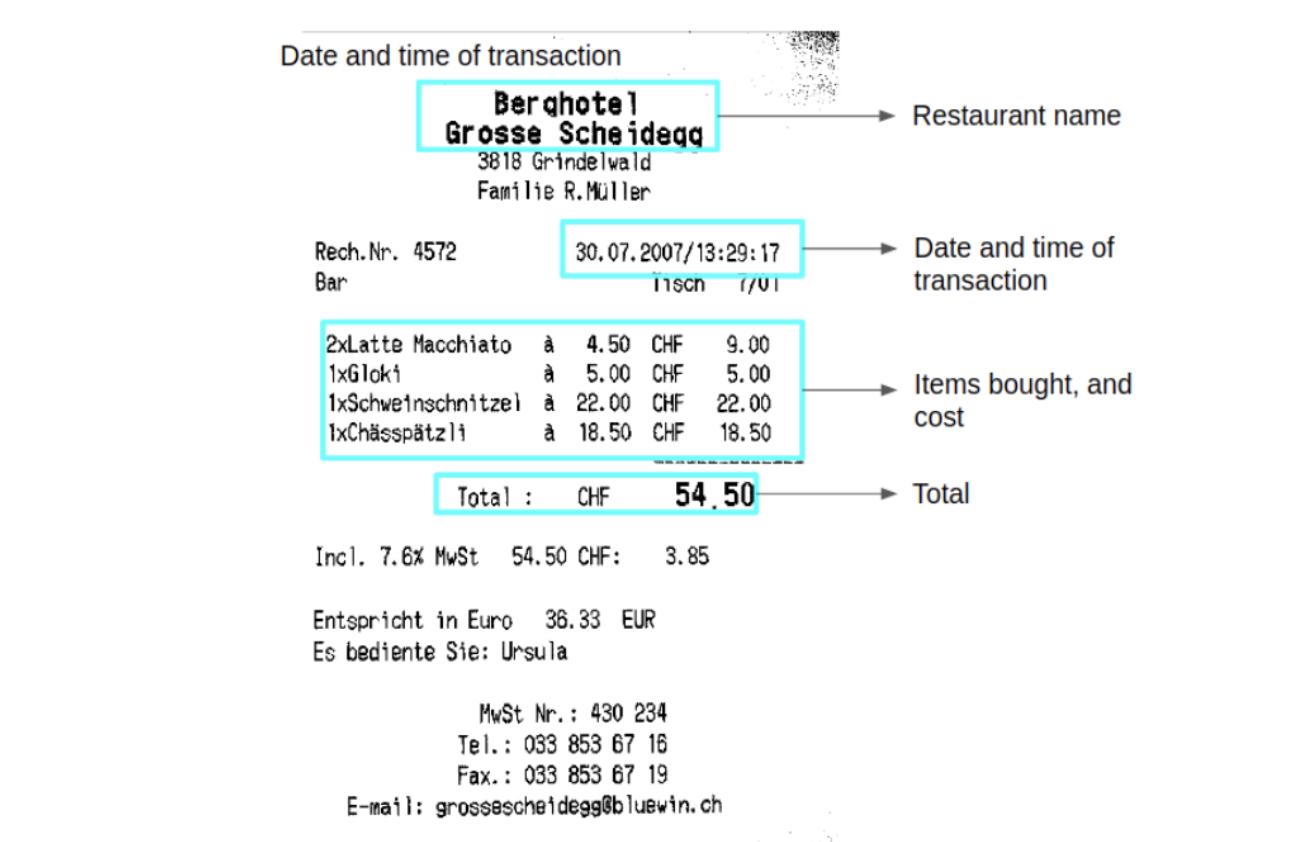

The LayoutLM model was proposed in the paper LayoutLM: Pre-training of Text and Layout for Document Image Understanding by Yiheng Xu, Minghao Li, Lei Cui, Shaohan Huang, Furu Wei, and Ming Zhou. It’s a simple but effective pretraining method of text and layout for document image understanding and information extraction tasks, such as form understanding and receipt understanding. It obtains state-of-the-art results on several downstream tasks:

form understanding: the FUNSD dataset (a collection of 199 annotated forms comprising more than 30,000 words).

receipt understanding: the SROIE dataset (a collection of 626 receipts for training and 347 receipts for testing).

document image classification: the RVL-CDIP dataset (a collection of 400,000 images belonging to one of 16 classes).

The abstract from the paper is the following:

Pre-training techniques have been verified successfully in a variety of NLP tasks in recent years. Despite the widespread use of pretraining models for NLP applications, they almost exclusively focus on text-level manipulation, while neglecting layout and style information that is vital for document image understanding. In this paper, we propose the LayoutLM to jointly model interactions between text and layout information across scanned document images, which is beneficial for a great number of real-world document image understanding tasks such as information extraction from scanned documents. Furthermore, we also leverage image features to incorporate words’ visual information into LayoutLM. To the best of our knowledge, this is the first time that text and layout are jointly learned in a single framework for document-level pretraining. It achieves new state-of-the-art results in several downstream tasks, including form understanding (from 70.72 to 79.27), receipt understanding (from 94.02 to 95.24) and document image classification (from 93.07 to 94.42).

### OCR - Tesseract

Before applying the model for inference we need to get a receipt into digital form. The pytesseract library forms a wrapper around Tesseract which is an excellent tool for getting our tokens and coordinates. It reads images so first we have to get our pdf to image form. Conversion is easy with pdf2image.

In [1]:
!apt-get install -q poppler-utils

Reading package lists...
Building dependency tree...
Reading state information...
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 9 not upgraded.
Need to get 154 kB of archives.
After this operation, 613 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 poppler-utils amd64 0.62.0-2ubuntu2.12 [154 kB]
Fetched 154 kB in 1s (103 kB/s)
debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package poppler-utils.
(Reading database ... 112204 files and directories currently installed.)
Preparing to unpack .../poppler-utils_0.62.0-2ubuntu2.12_amd64.deb ...
Unpacking poppler-utils (0.62.0-2ubuntu2.12) ...
Setting up poppler-utils (0.62.0-2ubuntu2.12) ...


In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import subprocess

from pdf2image import convert_from_path
from PIL import Image
import pytesseract

import glob
import json 
import random
from pathlib import Path
from difflib import SequenceMatcher


import cv2
import pandas as pd
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
from IPython.display import display
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import pyplot, patches

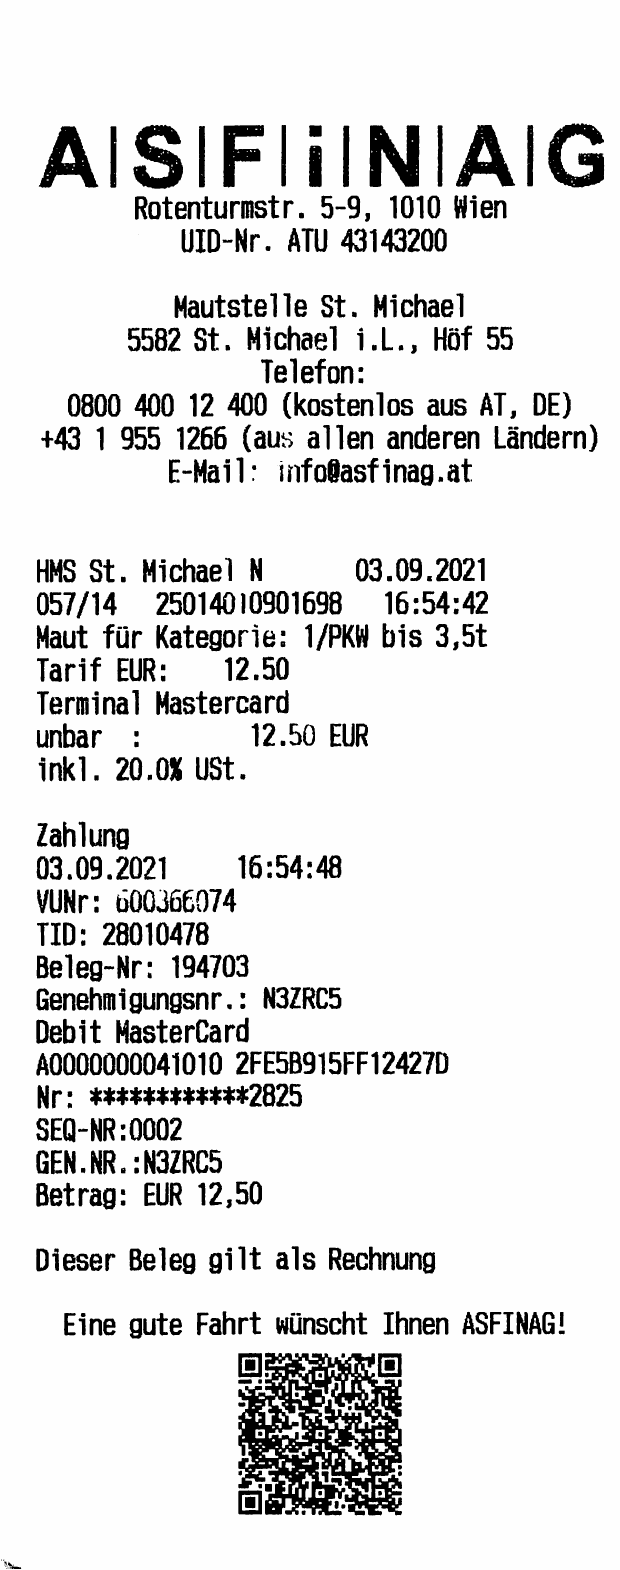

In [3]:
file = "../input/my-receipts/my-receipts/2021/at/20210906_001.pdf"

image = convert_from_path(file)[0]
image

Each bounding box should be in (x0, y0, x1, y1) format, where (x0, y0) corresponds to the position of the upper left corner in the bounding box, and (x1, y1) represents the position of the lower right corner. Note that one first needs to normalize the bounding boxes to be on a 0-1000 scale.

In [4]:
width, height = image.size
w_scale = 1000/width
h_scale = 1000/height

ocr_df = pytesseract.image_to_data(image, output_type='data.frame')

ocr_df = ocr_df.dropna() \
               .assign(left_scaled = ocr_df.left*w_scale,
                       width_scaled = ocr_df.width*w_scale,
                       top_scaled = ocr_df.top*h_scale,
                       height_scaled = ocr_df.height*h_scale,
                       right_scaled = lambda x: x.left_scaled + x.width_scaled,
                       bottom_scaled = lambda x: x.top_scaled + x.height_scaled)

#Bounding Box
# X0,Y0 = Left, Top
# X1,Y1 = right, Bottom

float_cols = ocr_df.select_dtypes('float').columns
ocr_df[float_cols] = ocr_df[float_cols].round(0).astype(int)
display(ocr_df.head())

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text,left_scaled,width_scaled,top_scaled,height_scaled,right_scaled,bottom_scaled
4,5,1,1,1,1,1,309,123,295,64,76,iINIAIG,498,476,78,41,974,119
8,5,1,2,1,1,1,135,195,169,25,91,Rotenturmstr.,218,273,124,16,490,140
9,5,1,2,1,1,2,321,196,49,26,96,"5-9,",518,79,125,17,597,141
10,5,1,2,1,1,3,390,196,50,23,96,1010,629,81,125,15,710,139
11,5,1,2,1,1,4,454,195,53,23,96,Wien,732,85,124,15,818,139


### Working on SROIE Dataset

#### Reading the words and bounding boxes:
So, the first step is reading the OCR data, where every line in the file includes a group of words and a bounding box which defines them. All we have to do is read the file, discard the unneeded points in the bounding box (because the model requires only the top-left and bottom-right points) and save it in Pandas Dataframe.

In [5]:
BBOX_TEXT_PATH = Path("/kaggle/input/receipts/receipts/train/")

text_files = [file for file in os.listdir(BBOX_TEXT_PATH) if '.txt' in file]
image_files = [file for file in os.listdir(BBOX_TEXT_PATH) if '.jpg' in file]

print(image_files[:2], text_files[:2])

['X51007231344.jpg', 'X51005442344.jpg'] ['X51005705760.txt', 'X51005605284(4).txt']


In [6]:
def read_bbox_and_words(path: Path):
    bbox_and_words_list = []

    with open(path, 'r') as f:
        for line in f.read().splitlines():
            split_lines = line.split(",")

            bbox = np.array(split_lines[0:8], dtype=np.int32)
            text = ",".join(split_lines[8:])

            # From the splited line we save (filename, [bounding box points], text line).
            # The filename will be useful in the future
            bbox_and_words_list.append([path.stem, *bbox, text])
    
        dataframe = pd.DataFrame(bbox_and_words_list, columns=['filename', 'x0', 'y0', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'line'], dtype=np.int16)
        dataframe = dataframe.drop(columns=['x1', 'y1', 'x3', 'y3'])

    return dataframe

bbox_df = read_bbox_and_words(BBOX_TEXT_PATH / text_files[0]).head(5)

### Reading the entities file
Now we need to read the entities file to know what to label in our text.

In [7]:
ENTITIES_PATH = Path("/kaggle/input/receipts/receipts/test")

ent_text_files = [file for file in os.listdir(ENTITIES_PATH) if '.txt' in file]
ent_image_files = [file for file in os.listdir(ENTITIES_PATH) if '.jpg' in file]

In [8]:
def read_entities(path: Path):
    with open(path, 'r') as f:
        data = json.load(f)

    dataframe = pd.DataFrame([data])
    
    return dataframe

entities = read_entities(path= ENTITIES_PATH / text_files[0])
entities.head(5)

,company,date,address,total
0,TRI SHAAS SDN BHD,10/08/2017,"4-20, JALAN RIA 25/62 TAMAN SRI MUDA SEKSYEN 2...",21.40


,filename,x0,y0,x2,y2,line
0,X51005705760,216,255,565,351,MYDIN
1,X51005705760,152,355,623,411,TRI SHAAS SDN BHD (728515-M)
2,X51005705760,233,402,556,451,MYDIN MART SRI MUDA
3,X51005705760,75,439,689,495,"4-20, JALAN RIA 25/62 TAMAN SRI MUDA"
4,X51005705760,88,483,683,534,"SEKSYEN 25, 40400 SHAH ALAM SELANGOR"


,company,date,address,total
0,TRI SHAAS SDN BHD,10/08/2017,"4-20, JALAN RIA 25/62 TAMAN SRI MUDA SEKSYEN 2...",21.40


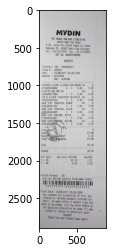

In [9]:
display(bbox_df.query("filename == 'X51005705760'"))
display(read_entities(path= Path(ENTITIES_PATH / 'X51005705760.txt')))
img = plt.imread(ENTITIES_PATH / 'X51005705760.jpg')

_ = plt.imshow(img)

In [10]:
line = bbox_df.query("filename == 'X51005705760'")['line'][3]
line

'4-20, JALAN RIA 25/62 TAMAN SRI MUDA'

#### Assigning labels to words using the entities data

We have our words/lines and entities, now we just need to put them together by labeling our lines using the entities values. We'll be doing that by substring matching the entities values with the lines and if they don't match to a similarity check using pythons difflib.SequenceMatcher and assigning anything above the 0.8 (80%) prediction match.

The label "O" will define all our words not labeled during the assignment step, because it's required for us to label everything.

In [11]:
for col_idx, col in enumerate(entities):
    print(entities.iloc[0,col_idx])

TRI SHAAS SDN BHD
10/08/2017
4-20, JALAN RIA 25/62 TAMAN SRI MUDA SEKSYEN 25, 40400 SHAH ALAM SELANGOR
21.40


In [12]:
def fetch_label(line : str, entities : pd.DataFrame):
    line_val = line.replace(',','').strip().split()
    
    for col_idx, col in enumerate(entities):
        
        entity = entities.iloc[0, col_idx].replace(',','').strip()
        # Split the words in the entity
        entity_val = entity.split()

        matches_count = 0

        for l in line_val:
            
            if any(SequenceMatcher(a=l, b=b).ratio() > 0.8 for b in entity_val):
                matches_count += 1

        if matches_count == len(line_val) or matches_count == len(entity_val):
            return col.upper()
        
    return 'O'

In [13]:
label = fetch_label(line, entities)
print('Line : ', line)
print('Label : ', label)

Line :  4-20, JALAN RIA 25/62 TAMAN SRI MUDA
Label :  ADDRESS


With a function which can handle the labeling of our lines, we'll create another function to label all our line in one DataFrame (so one receipt).

As simple as this could be, the problem arises when we get lines which would all pass the same match, like TOTAL for example; a receipt could have only one item on it and its price could be the same as the final total, so duplicate labels. Or maybe part of the address is also present at the end of the receipt.

To ignore such examples, I wrote simple hard-coded rules to assign total and date to only the largest bounding boxes it could find (based on its area) and to not allow the address to be assigned after date or total.

In [14]:
def assign_labels(words: pd.DataFrame, entities: pd.DataFrame):
    max_area = {"TOTAL": (0, -1), "DATE": (0, -1)}  # Value, index
    already_labeled = {"TOTAL": False,
                       "DATE": False,
                       "ADDRESS": False,
                       "COMPANY": False,
                       "O": False
    }

    # Go through every line in $words and assign it a label
    labels = []
    for i, line in enumerate(words['line']):
        label = fetch_label(line, entities)

        already_labeled[label] = True
        if label == "ADDRESS" and (already_labeled["DATE"] or already_labeled["TOTAL"]):
            label = "O"

        # Assign to the largest bounding box
        if label in ["TOTAL", "DATE"]:
            x0_loc = words.columns.get_loc("x0")
            bbox = words.iloc[i, x0_loc:x0_loc+4].to_list()
            area = (bbox[2] - bbox[0]) + (bbox[3] - bbox[1])

            if max_area[label][0] < area:
                max_area[label] = (area, i)

            label = "O"

        labels.append(label)

    labels[max_area["DATE"][1]] = "DATE"
    labels[max_area["TOTAL"][1]] = "TOTAL"

    words["label"] = labels
    return words


# Example usage
bbox_labeled = assign_labels(bbox_df, entities)
bbox_labeled.head(25)

,filename,x0,y0,x2,y2,line,label
0,X51005705760,216,255,565,351,MYDIN,O
1,X51005705760,152,355,623,411,TRI SHAAS SDN BHD (728515-M),COMPANY
2,X51005705760,233,402,556,451,MYDIN MART SRI MUDA,O
3,X51005705760,75,439,689,495,"4-20, JALAN RIA 25/62 TAMAN SRI MUDA",ADDRESS
4,X51005705760,88,483,683,534,"SEKSYEN 25, 40400 SHAH ALAM SELANGOR",TOTAL


### Split words
For the last part we're splitting the lines into separate tokens with their own bounding boxes.

Splitting the bounding boxes based on word length is probably not the best approach, but it's good enough.

In [15]:
def split_line(line: pd.Series):
    line_copy = line.copy()

    line_str = line_copy.loc["line"]
    words = line_str.split(" ")

    # Filter unwanted tokens
    words = [word for word in words if len(word) >= 1]

    x0, y0, x2, y2 = line_copy.loc[['x0', 'y0', 'x2', 'y2']]
    bbox_width = x2 - x0
  

    new_lines = []
    for index, word in enumerate(words):
        x2 = x0 + int(bbox_width * len(word)/len(line_str))
        line_copy.at['x0', 'x2', 'line'] = [x0, x2, word]
        new_lines.append(line_copy.to_list())
        x0 = x2 + 5 

    return new_lines


# Example usage
new_lines = split_line(bbox_labeled.loc[1])
print("Original row:")
display(bbox_labeled.loc[1:1,:])

print("Splitted row:")
pd.DataFrame(new_lines, columns=bbox_labeled.columns)

Original row:


,filename,x0,y0,x2,y2,line,label
1,X51005705760,152,355,623,411,TRI SHAAS SDN BHD (728515-M),COMPANY


Splitted row:


,filename,x0,y0,x2,y2,line,label
0,X51005705760,152,355,202,411,TRI,COMPANY
1,X51005705760,207,355,291,411,SHAAS,COMPANY
2,X51005705760,296,355,346,411,SDN,COMPANY
3,X51005705760,351,355,401,411,BHD,COMPANY
4,X51005705760,406,355,574,411,(728515-M),COMPANY


### Putting it all together

We defined all our functions, now we just have to use them on every file and transform the dataset into a format which the script/model can parse.

In [16]:
def dataset_creator(bbox_path : Path, ent_path : Path, total=1000):
    bbox_folder = bbox_path
    entities_folder = ent_path

      # Ignoring unwanted files which produced problems when I wanted to fine-tune the model with them included
    ignore = ['X51006619545.txt', 'X51006619785.txt', 'X51005663280(1).txt', 'X51005663280.txt'] 
    files = [file for file in bbox_folder.glob("*.txt") if file.name not in ignore]
    files = files[:total]

    data = []

    print("Reading dataset:")
    for file in tqdm(files, total=len(files)):
        bbox_file_path = file
        entities_file_path = entities_folder / file.name
        image_file_path = bbox_folder / file.with_suffix(".jpg")
  
        # Check if all the required files exist
        if not bbox_file_path.is_file() or not entities_file_path.is_file() or not image_file_path.is_file():
            continue
  
        # Read the files
        bbox = read_bbox_and_words(bbox_file_path)
        entities = read_entities(entities_file_path)
        image = Image.open(image_file_path)

        # Assign labels to lines in bbox using entities
        bbox_labeled = assign_labels(bbox, entities)
        del bbox

        # Split lines into separate tokens
        new_bbox_l = []
        for index, row in bbox_labeled.iterrows():
            new_bbox_l += split_line(row)
        new_bbox = pd.DataFrame(new_bbox_l, columns=bbox_labeled.columns, dtype=np.int16)
        del bbox_labeled


        # Do another label assignment to keep the labeling more precise 
        for index, row in new_bbox.iterrows():
            label = row['label']

            if label != "O":
                entity = entities.iloc[0, entities.columns.get_loc(label.lower())]
                if row['line'] not in entity:
                    label = "O"
                else:
                    # Not really IOB tagging, but it gives the best results
                    label = "S-" + label
      
            new_bbox.at[index, 'label'] = label

        width, height = image.size
  
        data.append([new_bbox, width, height])

    return data


dataset = dataset_creator(BBOX_TEXT_PATH, ENTITIES_PATH)

Reading dataset:


  0%|          | 0/832 [00:00<?, ?it/s]

### Tran & Test Data

In [17]:
random.Random(4).shuffle(dataset)

# Set split point to be 80% of the dataset
split_point = int(len(dataset) * 0.8) 

dataset_train  = dataset[:split_point]
dataset_test = dataset[split_point:]
del(dataset)

### Defining the writing function

We'll use the same function to write into the train and test files

The normalization function is meant to normalize the bounding boxes points in a range [0,1000] using the width and height of the image of the receipt

In [18]:
def normalize(points: list, width: int, height: int) -> list:
    x0, y0, x2, y2 = [int(p) for p in points]
  
    x0 = int(1000 * (x0 / width))
    x2 = int(1000 * (x2 / width))
    y0 = int(1000 * (y0 / height))
    y2 = int(1000 * (y2 / height))

    return [x0, y0, x2, y2]


def write_dataset(dataset: list, output_dir: Path, name: str):
    print(f"Writing {name}ing dataset:")
    with open(output_dir / f"{name}.txt", "w+", encoding="utf8") as file, \
        open(output_dir / f"{name}_box.txt", "w+", encoding="utf8") as file_bbox, \
        open(output_dir / f"{name}_image.txt", "w+", encoding="utf8") as file_image:

        # Go through each dataset
        for datas in tqdm(dataset, total=len(dataset)):
            data, width, height = datas
        
            filename = data.iloc[0, data.columns.get_loc('filename')]

            # Go through every row in dataset
            for index, row in data.iterrows():
                bbox = [int(p) for p in row[['x0', 'y0', 'x2', 'y2']]]
                normalized_bbox = normalize(bbox, width, height)

                file.write("{}\t{}\n".format(row['line'], row['label']))
                file_bbox.write("{}\t{} {} {} {}\n".format(row['line'], *normalized_bbox))
                file_image.write("{}\t{} {} {} {}\t{} {}\t{}\n".format(row['line'], *bbox, width, height, filename))

            # Write a second newline to separate dataset from others
            file.write("\n")
            file_bbox.write("\n")
            file_image.write("\n")

In [19]:
dataset_directory = Path('/kaggle/working','dataset')

dataset_directory.mkdir(parents=True, exist_ok=True)

write_dataset(dataset_train, dataset_directory, 'train')
write_dataset(dataset_test, dataset_directory, 'test')

# Creating the 'labels.txt' file to the the model what categories to predict.
labels = ['COMPANY', 'DATE', 'ADDRESS', 'TOTAL']
IOB_tags = ['S']
with open(dataset_directory / 'labels.txt', 'w') as f:
    for tag in IOB_tags:
        for label in labels:
            f.write(f"{tag}-{label}\n")
        f.write("O")

Writing training dataset:


  0%|          | 0/531 [00:00<?, ?it/s]

Writing testing dataset:


  0%|          | 0/133 [00:00<?, ?it/s]

### Model Setup

In [20]:
%%bash

cd /kaggle/working
git clone "https://github.com/microsoft/unilm.git"
cd unilm/layoutlm/deprecated
pip install -q .

Cloning into 'unilm'...
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
caip-notebooks-serverextension 1.0.0 requires google-cloud-bigquery-storage, which is not installed.
allennlp 2.7.0 requires transformers<4.10,>=4.1, but you have transformers 2.9.0 which is incompatible.


In [21]:
pretrained_model_folder_input=Path('/kaggle/input/layoutlm/layoutlmv2-base-uncased') # Define it so we can copy it into our working directory

pretrained_model_folder=Path('/kaggle/working/layoutlm-base-uncased/') 
label_file=Path(dataset_directory, "labels.txt")

# Move to the script directory
os.chdir("/kaggle/working/unilm/layoutlm/deprecated/examples/seq_labeling")

First I'm going to copy the pretrained base model into our working directory to change its configuration file, specificaly the number of attention heads the model should use. I changed the original number from 12 to 8 , because the model performs better with such hyperparameters.

In [22]:
! cp -r "{pretrained_model_folder_input}" "{pretrained_model_folder}"
! sed -i 's/"num_attention_heads": 16,/"num_attention_heads": 8,/' "{pretrained_model_folder}/"config.json

! cat "/kaggle/working/layoutlm-base-uncased/config.json"

{
  "attention_probs_dropout_prob": 0.1,
  "coordinate_size": 128,
  "fast_qkv": true,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "image_feature_pool_shape": [
    7,
    7,
    256
  ],
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_2d_position_embeddings": 1024,
  "max_position_embeddings": 512,
  "max_rel_2d_pos": 256,
  "max_rel_pos": 128,
  "model_type": "layoutlmv2",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "shape_size": 128,
  "rel_2d_pos_bins": 64,
  "rel_pos_bins": 32,
  "type_vocab_size": 2,
  "vocab_size": 30522
}


In [23]:
! rm -rf /kaggle/working/dataset/cached*

In [24]:
! python run_seq_labeling.py \
                            --data_dir /kaggle/working/dataset \
                            --labels /kaggle/working/dataset/labels.txt \
                            --model_name_or_path "{pretrained_model_folder}" \
                            --model_type layoutlm \
                            --max_seq_length 512 \
                            --do_lower_case \
                            --do_train \
                            --num_train_epochs 20 \
                            --logging_steps 50 \
                            --save_steps -1 \
                            --output_dir output \
                            --overwrite_output_dir \
                            --per_gpu_train_batch_size 8 \
                            --per_gpu_eval_batch_size 16

2021-09-28 14:20:19.989819: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Iteration:   0%|                                         | 0/67 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)

Iteration:  73%|███████████████████████▍        | 49/67 [00:23<00:08,  2.10it/s]/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:247: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "

Epoch: 100%|████████████████████████████████████| 20/20 [10:30<00:00, 

In [25]:
# Evaluate for test set and make predictions
! python run_seq_labeling.py \
                            --data_dir /kaggle/working/dataset \
                            --labels /kaggle/working/dataset/labels.txt \
                            --model_name_or_path  "{pretrained_model_folder}" \
                            --model_type layoutlm \
                            --do_lower_case \
                            --max_seq_length 512 \
                            --do_predict \
                            --logging_steps 10 \
                            --save_steps -1 \
                            --output_dir output \
                            --per_gpu_eval_batch_size 8

2021-09-28 14:31:22.082041: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Evaluating: 100%|███████████████████████████████| 17/17 [00:02<00:00,  6.74it/s]


In [26]:
cat output/test_results.txt

f1 = 0.8598519888991674
loss = 0.283491412506384
precision = 0.8527522935779817
recall = 0.867070895522388


### Prediction

In [27]:
import cv2
from matplotlib import pyplot, patches
import matplotlib

data = pd.read_csv("/kaggle/working/dataset/test_image.txt", delimiter="\t", names=["name", "bbox", "size", "image"])
data_category = pd.read_csv("/kaggle/working/dataset/test.txt", delimiter="\t", names=["name", "true_category"]).drop(columns=["name"])
data_prediction_category = pd.read_csv("output/test_predictions.txt", delimiter=" ", names=["name", "prediction_category"]).drop(columns=["name"])

data_merge = data.merge(data_category, left_index=True, right_index=True)
merged = data_merge.merge(data_prediction_category, left_index=True, right_index=True)
merged_groups = list(merged.groupby("image"))

In [28]:
merged.head(10)

,name,bbox,size,image,true_category,prediction_category
0,KEDAI,162 252 303 298,932 2211,X51008142059,S-COMPANY,S-COMPANY
1,PAPAN,308 252 449 298,932 2211,X51008142059,S-COMPANY,S-COMPANY
2,YEW,454 252 539 298,932 2211,X51008142059,S-COMPANY,S-COMPANY
3,CHUAN,544 252 685 298,932 2211,X51008142059,S-COMPANY,S-COMPANY
4,(0005583085-K),334 297 586 337,932 2211,X51008142059,O,O
5,LOT,252 344 311 380,932 2211,X51008142059,S-ADDRESS,S-ADDRESS
6,276,316 344 375 380,932 2211,X51008142059,S-ADDRESS,S-ADDRESS
7,JALAN,380 344 478 380,932 2211,X51008142059,S-ADDRESS,S-ADDRESS
8,BANTING,483 344 620 380,932 2211,X51008142059,S-ADDRESS,S-ADDRESS
9,43800,228 394 327 431,932 2211,X51008142059,S-ADDRESS,S-ADDRESS


In [29]:
def display_prediction(data):
    colors = {
      "S-TOTAL": (255,0,0),
      "S-DATE": (0,255,0),
      "S-ADDRESS": (0,0, 255),
      "S-COMPANY": (255,255,0),
      "O": (192,192,192)
  }

    imagename = data[0].split(".")[0] + ".jpg"
    print("Filename:",imagename)
    image_path = str(BBOX_TEXT_PATH / imagename)

    img=cv2.imread(image_path)
    img_prediction=cv2.imread(image_path)

    data = data[1]
    for bbox, category, prediction_category in zip(data['bbox'], data['true_category'], data['prediction_category']):
        (x1, y1, x2, y2) = [int(coordinate) for coordinate in bbox.split()]

        img_prediction = cv2.rectangle(img_prediction, (x1, y1), (x2, y2), colors[prediction_category], 2 if "O" in prediction_category else 4)
        img = cv2.rectangle(img, (x1, y1), (x2, y2), colors[category], 2 if "O" in category else 4)

    matplotlib.rcParams['figure.figsize'] = 15 ,18

    cv2.imwrite("prediction.jpg", img_prediction)

  # Plot
    fig, ax = matplotlib.pyplot.subplots(1,2)
    ax[0].set_title("Original", fontsize= 30)
    ax[0].imshow(img);
    ax[1].set_title("Prediction", fontsize= 30)
    ax[1].imshow(img_prediction);

  # Legend
    handles = [
      patches.Patch(color='yellow', label='Company'),
      patches.Patch(color='blue', label='Address'),
      patches.Patch(color='green', label='Date'),
      patches.Patch(color='red', label='Total'),
      patches.Patch(color='gray', label='Other')
  ]

    fig.legend(handles=handles, prop={'size': 25}, loc='lower center')

Filename: X00016469623.jpg


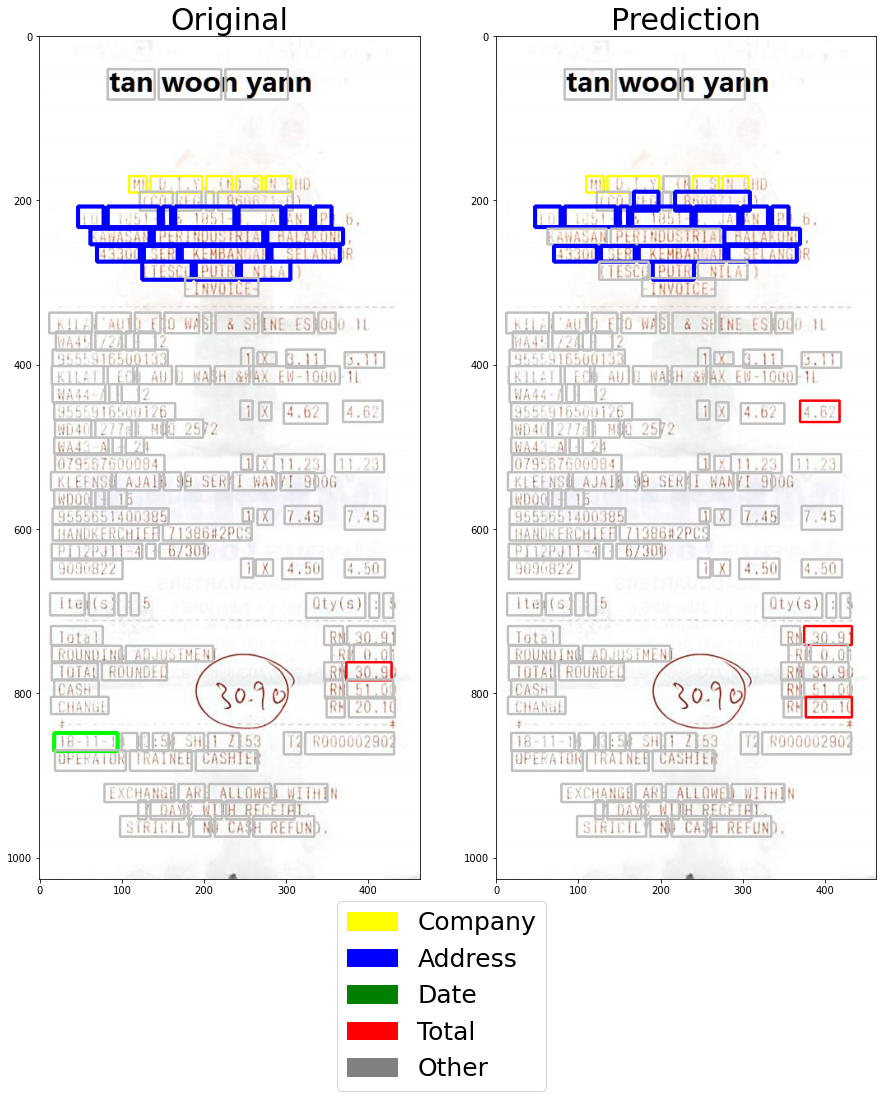

In [30]:
display_prediction(merged_groups[0])

In [31]:
import os

print(os.listdir('/kaggle/working/dataset'))
print(os.listdir('/kaggle/working/unilm/layoutlm/deprecated/examples/seq_labeling/output'))

['train.txt', 'cached_test_layoutlm-base-uncased_512', 'test_box.txt', 'labels.txt', 'test.txt', 'train_box.txt', 'test_image.txt', 'cached_train_layoutlm-base-uncased_512', 'train_image.txt']
['test_results.txt', 'pytorch_model.bin', 'test_predictions.txt', 'training_args.bin', 'vocab.txt', 'tokenizer_config.json', 'special_tokens_map.json', 'config.json']


In [32]:
output_dir = Path('/kaggle/working/unilm/layoutlm/deprecated/examples/seq_labeling/output')

with open(dataset_directory / 'train_box.txt', "r") as box, \
    open(dataset_directory / 'train_image.txt', "r") as image, \
    open(output_dir / 'test_predictions.txt', "r") as pred:
    
    print(box.read()[:100])
    print('********** \n\n')
    print(image.read()[:100])
    print('********** \n\n')
    print(pred.read()[:100])

TEO	291 158 323 176
HENG	325 158 368 176
STATIONERY	370 158 479 176
&	481 158 491 176
BOOKS	493 158 
********** 


TEO	723 557 803 618	2481 3508	X51005361900
HENG	808 557 915 618	2481 3508	X51005361900
STATIONERY	92
********** 


KEDAI S-COMPANY
PAPAN S-COMPANY
YEW S-COMPANY
CHUAN S-COMPANY
(0005583085-K) O
LOT S-ADDRESS
276 S-A
